In [7]:
drop_cols = ['Date', 'YEAR', 'DOY', 'HR',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 
       'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index']

# drop_cols = ['Date', 'YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
#        'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 
#        'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
#        'f10.7_index', 'Kp_gfz']

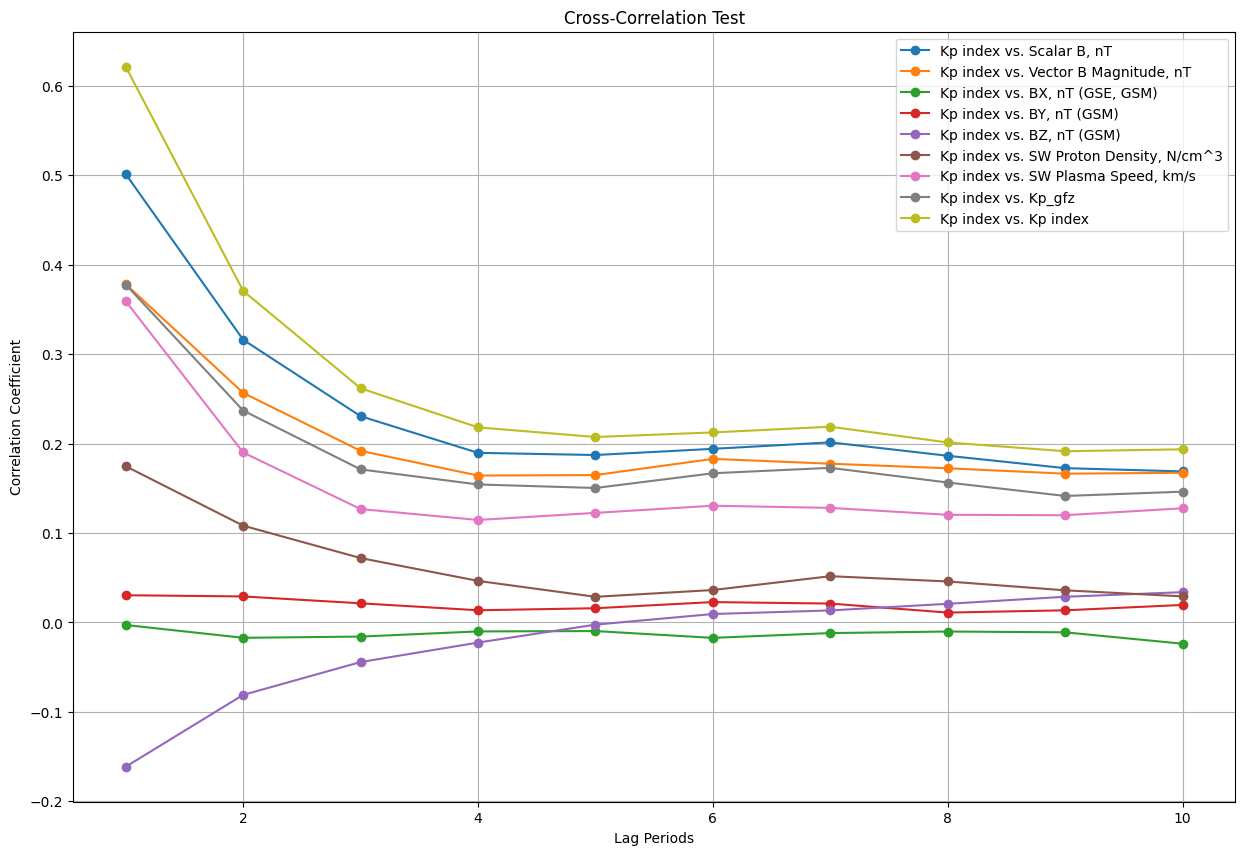

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
df = pd.read_csv("Data Files/CSV_files/omni_Kp_combined.csv")

def perform_cross_correlation_test(variable1, variable2, lag_periods):
    lags = []
    correlations = []
    for lag in range(1, lag_periods+1):
        df[f'{variable1}_lag_{lag}'] = df[variable1].shift(lag)
        df[f'{variable2}_lag_{lag}'] = df[variable2].shift(lag)
        df_lagged = df.dropna()
        result = np.corrcoef(df_lagged[variable1], df_lagged[f'{variable2}_lag_{lag}'])[0, 1]
        lags.append(lag)
        correlations.append(result)
    
    return lags, correlations



def perform_autocorrelation_test(variable, lag_periods):
    lags = []
    correlations = []
    for lag in range(1, lag_periods+1):
        df[f'{variable}_lag_{lag}'] = df[variable].shift(lag)
        df_lagged = df.dropna()
        result = np.corrcoef(df_lagged[variable], df_lagged[f'{variable}_lag_{lag}'])[0, 1]
        lags.append(lag)
        correlations.append(result)
    
    return lags, correlations

# Replace 'kp' and 'ap' with the actual column names you want to test for cross-correlation
variable1_name = 'Kp index'

plt.figure(figsize=(15, 10))
for column_name in df.drop(columns = drop_cols).columns:
    # print(column_name)
    
    lags, correlations = perform_cross_correlation_test(variable1_name, column_name, lag_periods=10)

    # Plotting the line plot
   
    plt.plot(lags, correlations, marker='o', linestyle='-', label=f'{variable1_name} vs. {column_name}')
    plt.xlabel('Lag Periods')
    plt.ylabel('Correlation Coefficient')
    plt.title(f'Cross-Correlation Test')
    plt.grid(True)




lags, correlations = perform_autocorrelation_test(variable1_name, lag_periods=10)

# Plotting the line plot
# plt.figure(figsize=(8, 6))
plt.plot(lags, correlations, marker='o', linestyle='-',  label = f'{variable1_name} vs. {variable1_name}' )
plt.legend()
plt.show()


In [2]:
df.columns

Index(['Date', 'YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz'],
      dtype='object')

In [11]:
df = pd.read_csv("Data Files/CSV_files/omni_Kp_combined.csv")

In [13]:
df.columns

Index(['Date', 'YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz'],
      dtype='object')

In [23]:
df[df["Kp_gfz"].isna()]

,Date,YEAR,DOY,HR,"Scalar B, nT","Vector B Magnitude, nT",Lat. Angle of B (GSE),Long. Angle of B (GSE),"BX, nT (GSE, GSM)","BY, nT (GSM)","BZ, nT (GSM)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.),"ap_index, nT",f10.7_index,Kp_gfz
0,1967-01-01,1967,1.0,0,7.6,2.7,2.2,156.9,-2.5,0.8,-0.1,14.1,410.0,30,103.0,18.0,124.4,NaN
20463,2023-01-10,2023,10.0,0,7.6,4.8,12.3,317.7,3.5,-3.2,0.5,9.7,363.0,13,178.0,6.0,186.6,NaN


In [14]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Load the timeseries data into a DataFrame df
# Replace 'YourColumn' with the actual column name containing the "kp" variable
# Make sure the DataFrame is sorted by date in ascending order
# Example: df = pd.read_csv('your_data.csv')
# df = df.sort_values('Date')

# Assuming df contains a column named "kp"
kp_data = df['Kp_gfz'].values
kp_data.dropna(inplace = True)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
kp_data_normalized = scaler.fit_transform(kp_data.reshape(-1, 1))

# Define the number of previous timesteps to use for prediction
n_timesteps = 6

# Create a TimeseriesGenerator to generate input sequences and their corresponding labels
generator = TimeseriesGenerator(kp_data_normalized, kp_data_normalized, length=n_timesteps, batch_size=1)

# Split the data into training and testing sets
train_size = int(0.8 * len(generator))
train_generator = generator[:train_size]
test_generator = generator[train_size:]

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit_generator(train_generator, epochs=50, verbose = 1)

# Evaluate the model on the test data
test_loss = model.evaluate_generator(test_generator)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict_generator(test_generator)

# Inverse transform the predictions to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)

# Print the predicted values for "kp"
print('Predicted "kp" values:')
print(predictions_inverse.flatten())


TypeError: unsupported operand type(s) for *: 'int' and 'slice'

In [16]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Load the timeseries data into a DataFrame df
# Replace 'YourColumn' with the actual column name containing the "kp" variable
# Make sure the DataFrame is sorted by date in ascending order
# Example: df = pd.read_csv('your_data.csv')
# df = df.sort_values('Date')

# Assuming df contains a column named "kp"
kp_data = df['Kp_gfz'].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
kp_data_normalized = scaler.fit_transform(kp_data.reshape(-1, 1))

# Define the number of previous timesteps to use for prediction
n_timesteps = 6

# Create a TimeseriesGenerator to generate input sequences and their corresponding labels
generator = TimeseriesGenerator(kp_data_normalized, kp_data_normalized, length=n_timesteps, batch_size=64)

# Split the data into training and testing sets
train_size = int(0.8 * len(generator))
train_generator = TimeseriesGenerator(kp_data_normalized, kp_data_normalized, length=n_timesteps, batch_size=1, end_index=train_size)
test_generator = TimeseriesGenerator(kp_data_normalized, kp_data_normalized, length=n_timesteps, batch_size=1, start_index=train_size)

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit_generator(train_generator, epochs=50)

# Evaluate the model on the test data
test_loss = model.evaluate_generator(test_generator)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict_generator(test_generator)

# Inverse transform the predictions to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)

# Print the predicted values for "kp"
print('Predicted "kp" values:')
print(predictions_inverse.flatten())


Epoch 1/50


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\2295923153.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=50)


123/123 [==============================] - 2s 3ms/step - loss: nan
Epoch 2/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 3/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 5/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 6/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 7/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 8/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 9/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 10/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 11/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 12/50
123/123 [==============================] - 0s 3ms/step - loss: nan
Epoch 13/50
123/123 [==============================] - 0s 3ms/step - los

C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\2295923153.py:43: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss = model.evaluate_generator(test_generator)


Test Loss: nan


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\2295923153.py:47: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


Predicted "kp" values:
[nan nan nan ... nan nan nan]


In [17]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

# Load the timeseries data into a DataFrame df
# Replace 'YourColumn' with the actual column name containing the "kp" variable
# Make sure the DataFrame is sorted by date in ascending order
# Example: df = pd.read_csv('your_data.csv')
# df = df.sort_values('Date')

# Assuming df contains a column named "kp"
kp_data = df['Kp_gfz'].values

# Define the number of previous timesteps to use for prediction
n_timesteps = 6

# Create a TimeseriesGenerator to generate input sequences and their corresponding labels
generator = TimeseriesGenerator(kp_data, kp_data, length=n_timesteps, batch_size=64)

# Split the data into training and testing sets
train_size = int(0.8 * len(generator))
train_generator = TimeseriesGenerator(kp_data, kp_data, length=n_timesteps, batch_size=1, end_index=train_size)
test_generator = TimeseriesGenerator(kp_data, kp_data, length=n_timesteps, batch_size=1, start_index=train_size)

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit_generator(train_generator, epochs=50)

# Evaluate the model on the test data
test_loss = model.evaluate_generator(test_generator)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict_generator(test_generator)

# Print the predicted values for "kp" without inverse scaling
print('Predicted "kp" values:')
print(predictions.flatten())


Epoch 1/50


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\4038136842.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=50)


251/251 [==============================] - 3s 3ms/step - loss: nan
Epoch 2/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 3/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 4/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 5/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 6/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 7/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 8/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 9/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 10/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 11/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 12/50
251/251 [==============================] - 1s 3ms/step - loss: nan
Epoch 13/50
251/251 [==============================] - 1s 3ms/step - los

C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\4038136842.py:38: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss = model.evaluate_generator(test_generator)


Test Loss: nan


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\4038136842.py:42: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


Predicted "kp" values:
[nan nan nan ... nan nan nan]


Epoch 1/50
256/256 [==============================] - 6s 11ms/step - loss: 0.0252
Epoch 2/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0228
Epoch 3/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 4/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 5/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 6/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 7/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 8/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 9/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 10/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0225
Epoch 11/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0225
Epoch 12/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0226
Epoch 13/50
2

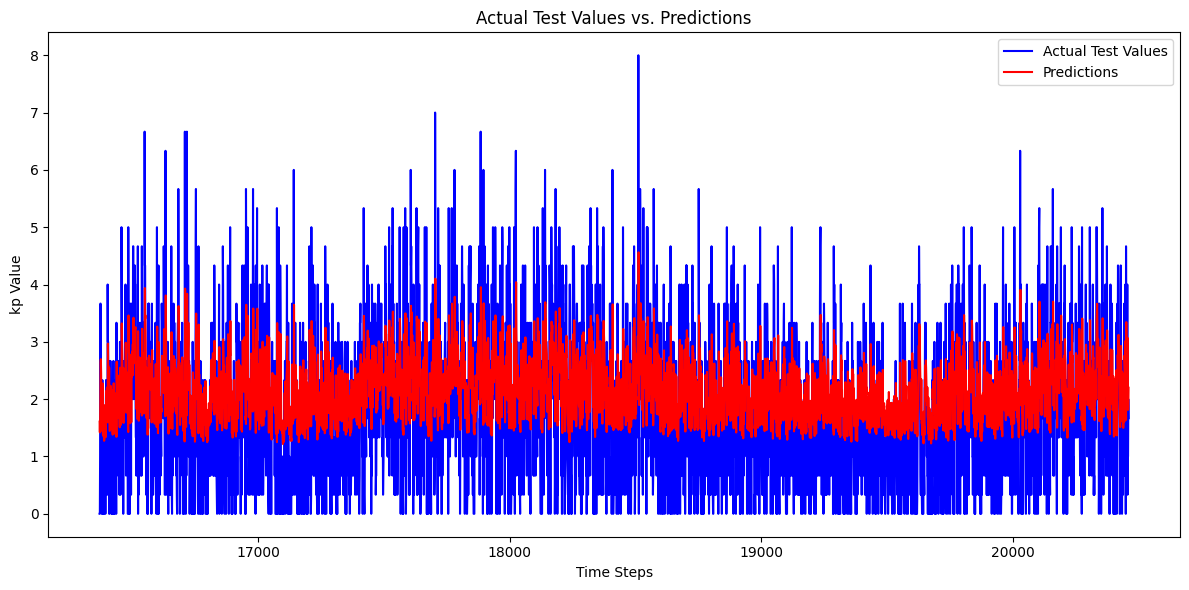

In [31]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the timeseries data into a DataFrame df
# Replace 'YourColumn' with the actual column name containing the "kp" variable
# Make sure the DataFrame is sorted by date in ascending order
# Example: df = pd.read_csv('your_data.csv')
# df = df.sort_values('Date')

# Assuming df contains a column named "kp"
kp_data = df['Kp_gfz']
kp_data.dropna(inplace = True)
kp_data = kp_data.values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
kp_data_normalized = scaler.fit_transform(kp_data.reshape(-1, 1))

# Define the number of previous timesteps to use for prediction
n_timesteps = 6

# Manually create input samples and labels
X = []
y = []
for i in range(len(kp_data_normalized) - n_timesteps):
    X.append(kp_data_normalized[i:i+n_timesteps])
    y.append(kp_data_normalized[i+n_timesteps])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Reshape the data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], n_timesteps, 1))
X_test = np.reshape(X_test, (X_test.shape[0], n_timesteps, 1))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, 1), return_sequences = True))
model.add(LSTM(100, input_shape=(n_timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# Inverse transform the predictions to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)

# Inverse transform the test data to get the original scale
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the test values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(range(train_size + n_timesteps, len(kp_data)), y_test_inverse, label='Actual Test Values', color='blue')
plt.plot(range(train_size + n_timesteps, len(kp_data)), predictions_inverse.flatten(), label='Predictions', color='red')
plt.xlabel('Time Steps')
plt.ylabel('kp Value')
plt.title('Actual Test Values vs. Predictions')
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
df.Kp_gfz.isna().sum()

2

1/1 [==============================] - 0s 22ms/step


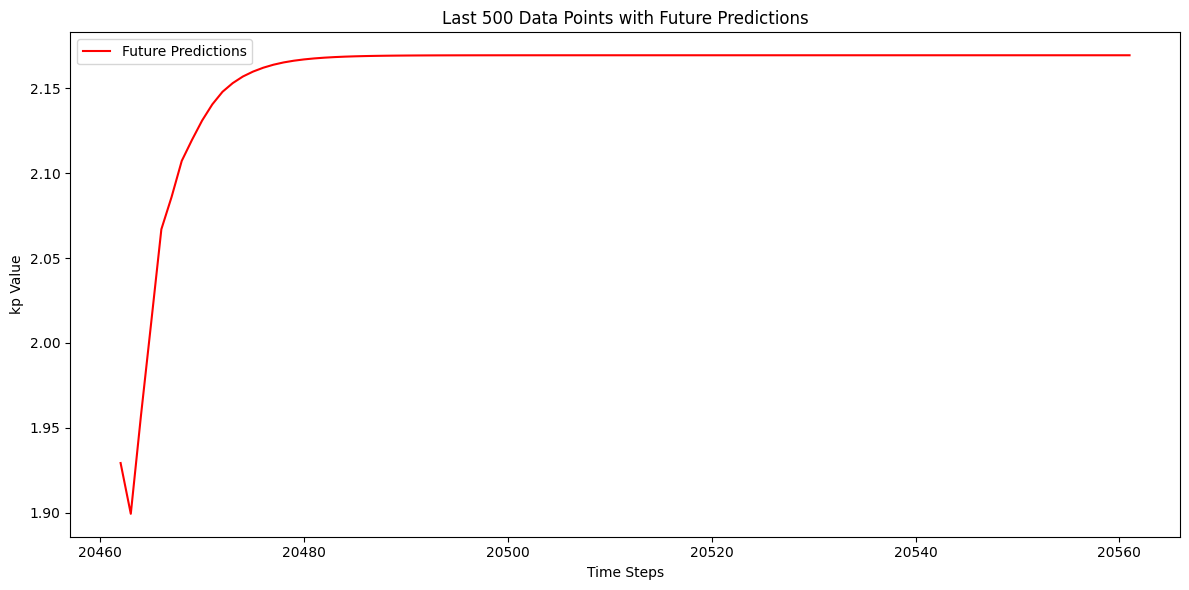

In [30]:
# Use the last n_timesteps data points from the original kp_data as input for prediction
input_sequence = kp_data[-n_timesteps:]
input_sequence_normalized = scaler.transform(input_sequence.reshape(-1, 1))

# Initialize an empty list to store the predictions
future_predictions = []

# Predict the next 100 time steps in the future
for i in range(100):
    # Reshape the input sequence for the model prediction
    input_data = np.array(input_sequence_normalized[-n_timesteps:]).reshape(1, n_timesteps, 1)
    
    # Use the model to predict the next time step
    prediction = model.predict(input_data)
    
    # Inverse transform the prediction to get the original scale
    prediction_inverse = scaler.inverse_transform(prediction)
    
    # Append the prediction to the list of future predictions
    future_predictions.append(prediction_inverse[0, 0])
    
    # Update the input sequence for the next prediction
    input_sequence_normalized = np.append(input_sequence_normalized, prediction, axis=0)

# Create an array of time steps for the future predictions
future_time_steps = np.arange(len(kp_data), len(kp_data) + len(future_predictions))

# Extract the last 500 data points from the original kp_data
last_500_kp_data = kp_data[-500:]

# Plot the last 500 data points and the future predictions
plt.figure(figsize=(12, 6))
# plt.plot(range(len(last_500_kp_data)), last_500_kp_data, label='Last 500 Data Points', color='blue')
plt.plot(future_time_steps, future_predictions, label='Future Predictions', color='red')
plt.xlabel('Time Steps')
plt.ylabel('kp Value')
plt.title('Last 500 Data Points with Future Predictions')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
df.columns

Index(['Date', 'YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz'],
      dtype='object')

In [36]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the timeseries data into a DataFrame df
# Replace 'YourColumn' with the actual column names containing the variables
# Make sure the DataFrame is sorted by date in ascending order
# Example: df = pd.read_csv('your_data.csv')
# df = df.sort_values('Date')

# Assuming df contains columns named "kp", "Proton Density", "Plasma Speed", and "Scaled Magnetic Amplitude"

data = df.loc['2000-01-01':'2014-12-31'][['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define the number of previous timesteps to use for prediction
n_timesteps = 6

# Manually create input samples and labels
X = []
y = []
for i in range(n_timesteps, len(data_normalized)):
    X.append(data_normalized[i-n_timesteps:i])
    y.append(data_normalized[i, 0])  # Predicting the next "kp" value

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Reshape the data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], n_timesteps, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], n_timesteps, X_test.shape[2]))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# # Make predictions for the test data
# predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data to get the original scale for "kp"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# # Calculate RMSE and MAE
# rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
# mae = mean_absolute_error(y_test_inverse, predictions_inverse)
# print('Root Mean Squared Error (RMSE):', rmse)
# print('Mean Absolute Error (MAE):', mae)

# # Use the last n_timesteps data points from the original data as input for future prediction
# input_data = data_normalized[-n_timesteps:]

# # Initialize an empty list to store the future predictions
# future_predictions = []

# # Predict the next 100 time steps in the future
# for i in range(100):
#     # Reshape the input data for the model prediction
#     input_data_reshaped = np.array(input_data[-n_timesteps:]).reshape(1, n_timesteps, input_data.shape[1])
    
#     # Use the model to predict the next "kp" value
#     prediction = model.predict(input_data_reshaped)
    
#     # Inverse transform the prediction to get the original



# Make predictions for the test data
predictions = model.predict(X_test)

# Inverse transform the predictions to get the original scale
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform the test data to get the original scale for "kp"
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)


Epoch 1/50
2/2 [==============================] - 2s 6ms/step - loss: 0.1397
Epoch 2/50
2/2 [==============================] - 0s 40ms/step - loss: 0.1111
Epoch 3/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0883
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0692
Epoch 5/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0575
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0482
Epoch 7/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0455
Epoch 8/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0457
Epoch 9/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0482
Epoch 10/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0506
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0513
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0502
Epoch 13/50
2/2 [==============================] - 0s 8ms/step - loss

ValueError: non-broadcastable output operand with shape (27,1) doesn't match the broadcast shape (27,4)

In [93]:
start_date = '2000-01-01'
end_date = '2014-12-31'
df2[(df2.index > start_date) & (df2.index < end_date)][['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]

,Kp_gfz,"SW Proton Density, N/cm^3","SW Plasma Speed, km/s","Vector B Magnitude, nT"
Date,,,,
2000-01-02,3.000,2.0,679.0,3.0
2000-01-03,3.333,2.3,588.0,3.7
2000-01-04,2.333,2.3,577.0,4.1
2000-01-05,4.000,2.3,521.0,4.0
2000-01-06,2.667,4.0,533.0,4.1
...,...,...,...,...
2014-12-26,4.000,5.3,456.0,7.0
2014-12-27,3.333,4.5,437.0,5.4
2014-12-28,2.333,9.9,389.0,6.8


In [90]:
df2.set_index('Date', inplace = True)

In [77]:
df2 = pd.read_csv("Data Files/CSV_files/omni_Kp_combined.csv")
df2.Date = pd.to_datetime(df2.Date)
df2.set_index('Date')

# # [['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]
df2[(df2.index>'2000-01-01') & (df2.index<'2014-12-31')]

TypeError: Invalid comparison between dtype=int64 and str

In [62]:
data.shape

(140, 4)

In [130]:
df2.columns

Index(['YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz'],
      dtype='object')

In [41]:
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data to get the original scale for "kp"
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 [==============================] - 0s 80ms/step


ValueError: non-broadcastable output operand with shape (27,1) doesn't match the broadcast shape (27,4)

In [37]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the timeseries data into a DataFrame df
# Replace 'YourColumn' with the actual column names containing the variables
# Make sure the DataFrame is sorted by date in ascending order
# Example: df = pd.read_csv('your_data.csv')
# df = df.sort_values('Date')

# Assuming df contains columns named "kp", "Proton Density", "Plasma Speed", and "Scaled Magnetic Amplitude"
# data = df[['kp', 'Proton Density', 'Plasma Speed', 'Scaled Magnetic Amplitude']].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define the number of previous timesteps to use for prediction
n_timesteps = 6

# Manually create input samples and labels
X = []
y = []
for i in range(n_timesteps, len(data_normalized)):
    X.append(data_normalized[i-n_timesteps:i])
    y.append(data_normalized[i, 0])  # Predicting the next "kp" value

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Reshape the data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], n_timesteps, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], n_timesteps, X_test.shape[2]))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# Inverse transform the predictions to get the original scale
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform the test data to get the original scale for "kp"
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Use the last n_timesteps data points from the original data as input for future prediction
input_data = data_normalized[-n_timesteps:]

# Initialize an empty list to store the future predictions
future_predictions = []

# Predict the next 100 time steps in the future
# for i in range(100):
#     # Reshape the input data for the model prediction
#     input_data_reshaped = np.array(input_data[-n_timesteps:]).reshape(1, n_timesteps, input_data.shape[1])
    
#     # Use the model to predict the next "kp" value
#     prediction = model.predict(input_data_reshaped)
    
#     # Inverse transform the prediction to get the original scale
#     prediction_inverse = scaler.inverse_transform(prediction)
    
#     # Append the prediction to the list of future predictions
#     future_predictions.append(prediction_inverse[0, 0])
    
#     # Update the input data for the next prediction
#     input_data = np.append(input_data, prediction_inverse, axis=0)

# # Create an array of time steps for the future predictions
# future_time_steps = np.arange(len(data), len(data) + len(future_predictions))

# Plot the actual data and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), data[:, 0], label='Actual Data (kp)', color='blue')
plt.plot(future_time_steps, future_predictions, label='Future Predictions (kp)', color='red')
plt.xlabel('Time Steps')
plt.ylabel('kp Value')
plt.title('Actual Data and Future Predictions for "kp"')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50
2/2 [==============================] - 2s 6ms/step - loss: 0.0797
Epoch 2/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0616
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0507
Epoch 4/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0459
Epoch 5/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0457
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0469
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 8/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0467
Epoch 9/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0451
Epoch 10/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0443
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0432
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0433
Epoch 13/50
2/2 [==============================] - 0s 7ms/step - loss: 0.

ValueError: non-broadcastable output operand with shape (27,1) doesn't match the broadcast shape (27,4)

In [ ]:
plt.plot(predictions_inverse)
plt.plot()

In [38]:
for i in range(100):
    print(i)
    # Reshape the input data for the model prediction
    input_data_reshaped = np.array(input_data[-n_timesteps:]).reshape(1, n_timesteps, input_data.shape[1])
    
    # Use the model to predict the next "kp" value
    prediction = model.predict(input_data_reshaped)
    
    # Inverse transform the prediction to get the original scale
    prediction_inverse = scaler.inverse_transform(prediction)
    
    # Append the prediction to the list of future predictions
    future_predictions.append(prediction_inverse[0, 0])
    
    # Update the input data for the next prediction
    input_data = np.append(input_data, prediction_inverse, axis=0)

# Create an array of time steps for the future predictions
future_time_steps = np.arange(len(data), len(data) + len(future_predictions))

0


ValueError: cannot reshape array of size 6 into shape (1,6,6)

In [39]:
input_data

array([[[0.24106306],
        [0.24106306],
        [0.24106306],
        [0.24106306],
        [0.24106306],
        [0.24106306]]])

In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming you have the data in a DataFrame named 'df' with a column 'Kp' as the target variable
# and other features (if any) for prediction.

# Extract the target variable 'Kp' and any other features you want to use for prediction
# Example: features = df[['feature1', 'feature2', ...]]
start_date = '2000-01-01'
end_date = '2014-12-31'
df2[(df2.index > start_date) & (df2.index < end_date)][['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]

features = df2.loc['2001-01-01':'2003-12-31'][['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]
#  = df.drop(columns=['Kp_gfz'])
target = df2.loc['2001-01-01':'2003-12-31'][['Kp_gfz']]

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
# scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
scaled_target = target

# Prepare the input data for LSTM
# You can adjust the time_steps based on your data and prediction needs
time_steps = 6  # Number of past time steps to use for prediction
X = []
y = []
for i in range(len(scaled_features) - time_steps):
    X.append(scaled_features[i:i+time_steps])
    y.append(scaled_target[i+time_steps])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences = True,  input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(100))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose = 1)

# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse scale the predictions to get the actual Kp values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate the mean squared error or any other relevant evaluation metric
mse = np.mean((y_pred_inverse - y_test_inverse)**2)
print(f"Mean Squared Error: {mse}")


Epoch 1/100
73/73 [==============================] - 9s 28ms/step - loss: nan - val_loss: nan
Epoch 2/100
73/73 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 3/100
73/73 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 4/100
73/73 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 5/100
73/73 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 6/100
73/73 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 7/100
73/73 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 8/100
 8/73 [==>...........................] - ETA: 1s - loss: nan

KeyboardInterrupt: 

<AxesSubplot: ylabel='Date'>

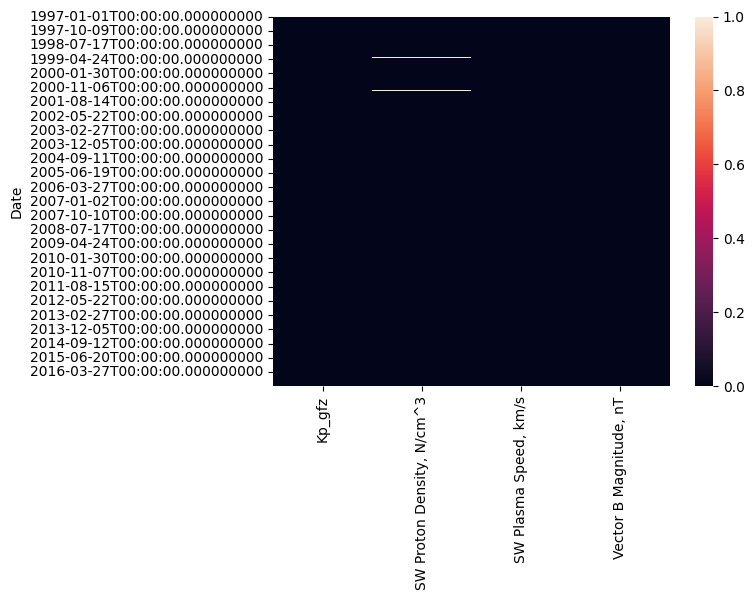

In [100]:
import seaborn as sns

sns.heatmap(features.isna())

In [58]:
y_pred = model.predict(X_test)

# Inverse scale the predictions to get the actual Kp values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 5ms/step


In [53]:
134*6

804

In [52]:
X.shape

(134, 6, 4)

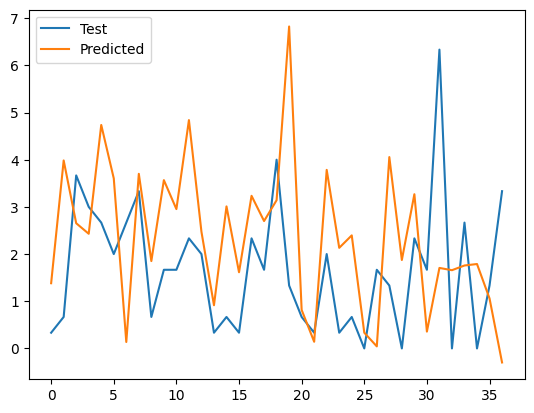

In [61]:

plt.plot(y_test_inverse, label = "Test")
plt.plot(y_pred_inverse, label = "Predicted")
plt.legend()
plt.show()

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = df2.loc['2001-01-01':'2003-12-31'][['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

In [113]:
df = df2.loc['2001-01-01':'2014-12-31'][['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]

Epoch 1/200
62/62 [==============================] - 2s 5ms/step - loss: 3.0596
Epoch 2/200
62/62 [==============================] - 0s 5ms/step - loss: 1.7283
Epoch 3/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6872
Epoch 4/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6551
Epoch 5/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6360
Epoch 6/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6253
Epoch 7/200
62/62 [==============================] - 0s 5ms/step - loss: 1.6219
Epoch 8/200
62/62 [==============================] - 0s 5ms/step - loss: 1.6109
Epoch 9/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6125
Epoch 10/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6082
Epoch 11/200
62/62 [==============================] - 0s 5ms/step - loss: 1.6198
Epoch 12/200
62/62 [==============================] - 0s 4ms/step - loss: 1.6058
Epoch 13/200
62/62 [=================

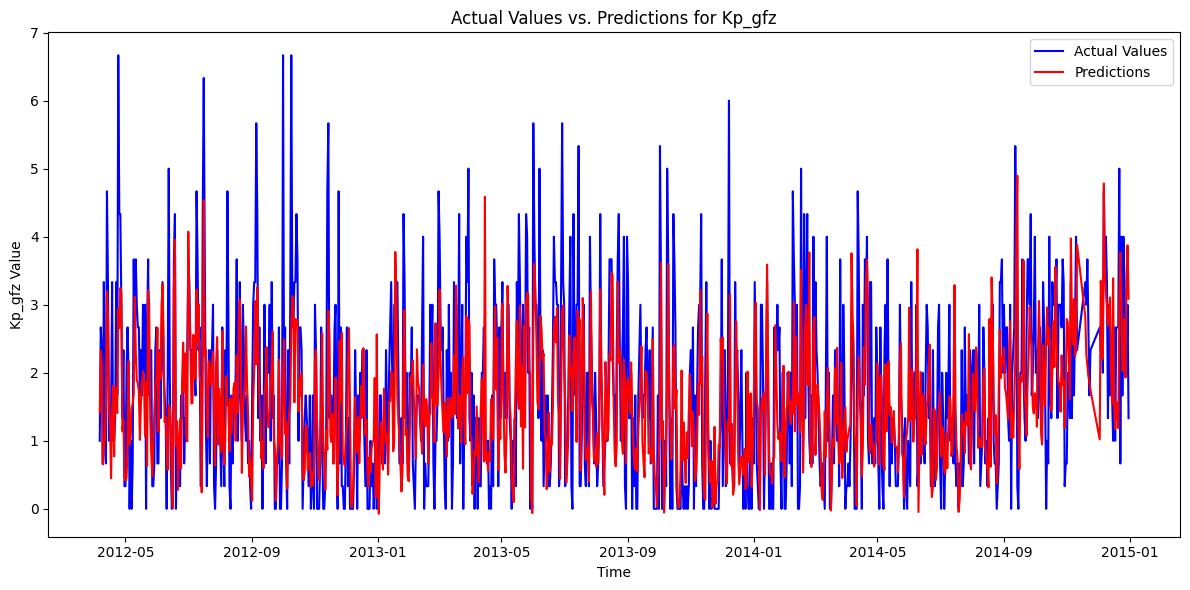

In [123]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, len(columns_to_lag))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()


154/154 [==============================] - 0s 3ms/step


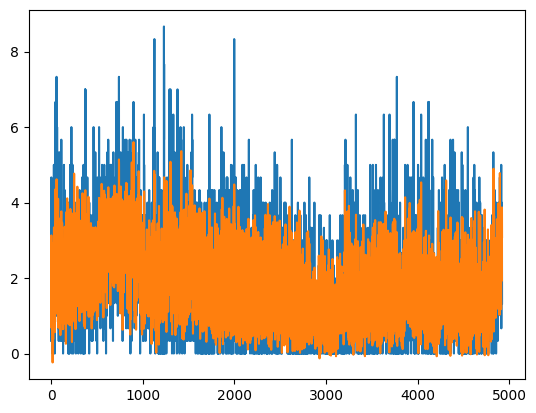

In [127]:
predictions = model.predict(features_normalized.reshape(features_normalized.shape[0], n_lags, len(columns_to_lag)))
plt.plot(labels)
plt.plot(predictions)

In [131]:
df2.columns

Index(['YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz'],
      dtype='object')

Epoch 1/200
170/170 [==============================] - 3s 6ms/step - loss: 2.3051
Epoch 2/200
170/170 [==============================] - 1s 6ms/step - loss: 1.7105
Epoch 3/200
170/170 [==============================] - 1s 6ms/step - loss: 1.6203
Epoch 4/200
170/170 [==============================] - 1s 6ms/step - loss: 1.5849
Epoch 5/200
170/170 [==============================] - 1s 6ms/step - loss: 1.5359
Epoch 6/200
170/170 [==============================] - 1s 6ms/step - loss: 1.5021
Epoch 7/200
170/170 [==============================] - 1s 6ms/step - loss: 1.4954
Epoch 8/200
170/170 [==============================] - 1s 6ms/step - loss: 1.4741
Epoch 9/200
170/170 [==============================] - 1s 6ms/step - loss: 1.4621
Epoch 10/200
170/170 [==============================] - 1s 6ms/step - loss: 1.4649
Epoch 11/200
170/170 [==============================] - 1s 6ms/step - loss: 1.4384
Epoch 12/200
170/170 [==============================] - 1s 6ms/step - loss: 1.4300
Epoch 13/200


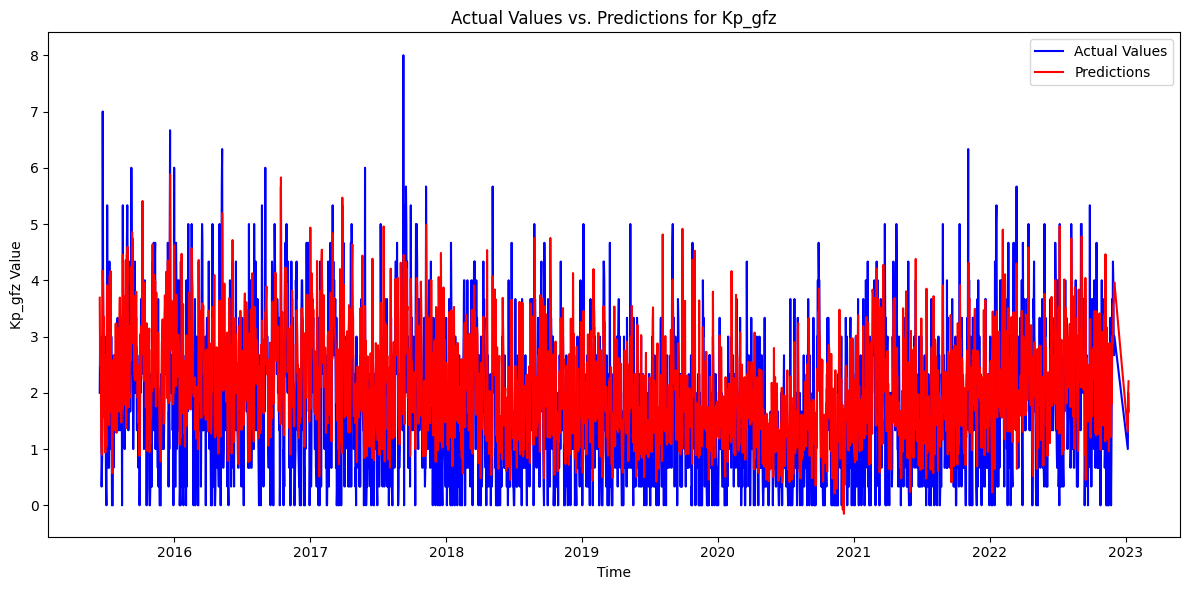

In [132]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
df = df2
# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)']
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, len(columns_to_lag))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()


In [136]:
df

,YEAR,DOY,HR,"Scalar B, nT","Vector B Magnitude, nT",Lat. Angle of B (GSE),Long. Angle of B (GSE),"BX, nT (GSE, GSM)","BY, nT (GSM)","BZ, nT (GSM)",...,"BY, nT (GSM)_lag_4","BY, nT (GSM)_lag_5","BY, nT (GSM)_lag_6","BZ, nT (GSM)_lag_1","BZ, nT (GSM)_lag_2","BZ, nT (GSM)_lag_3","BZ, nT (GSM)_lag_4","BZ, nT (GSM)_lag_5","BZ, nT (GSM)_lag_6",Kp_class
Date,,,,,,,,,,,,,,,,,,,,,
1967-01-17,1967,17.0,0,6.6,6.0,17.1,287.5,1.7,-5.6,0.7,...,-8.3,1.5,0.7,-1.7,0.5,-1.7,1.5,-0.1,-1.4,0
1967-01-18,1967,18.0,0,5.6,0.7,33.5,119.0,-0.3,0.6,0.5,...,-4.1,-8.3,1.5,0.7,-1.7,0.5,-1.7,1.5,-0.1,0
1967-01-19,1967,19.0,0,5.0,1.9,-1.7,132.5,-1.3,1.4,0.2,...,-4.1,-4.1,-8.3,0.5,0.7,-1.7,0.5,-1.7,1.5,0
1967-01-20,1967,20.0,0,7.0,3.9,-61.7,154.5,-1.7,1.1,-3.4,...,-2.8,-4.1,-4.1,0.2,0.5,0.7,-1.7,0.5,-1.7,0
1967-01-21,1967,21.0,0,5.8,3.9,-50.3,174.2,-2.5,0.7,-2.8,...,-5.6,-2.8,-4.1,-3.4,0.2,0.5,0.7,-1.7,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,2022,335.0,0,7.7,5.5,-1.6,136.3,-4.0,3.6,-0.8,...,3.4,3.5,5.7,0.5,-2.2,0.0,-1.1,-0.4,0.0,0
2022-12-02,2022,336.0,0,4.9,2.2,13.3,135.0,-1.5,1.5,0.5,...,3.6,3.4,3.5,-0.8,0.5,-2.2,0.0,-1.1,-0.4,0
2023-01-07,2023,7.0,0,7.1,5.2,28.9,304.5,2.6,-4.0,2.1,...,1.8,1.6,1.6,4.0,2.6,4.3,-0.4,-0.4,-0.2,0


In [137]:
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)']
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

In [139]:
df

,YEAR,DOY,HR,"Scalar B, nT","Vector B Magnitude, nT",Lat. Angle of B (GSE),Long. Angle of B (GSE),"BX, nT (GSE, GSM)","BY, nT (GSM)","BZ, nT (GSM)",...,"BY, nT (GSM)_lag_4","BY, nT (GSM)_lag_5","BY, nT (GSM)_lag_6","BZ, nT (GSM)_lag_1","BZ, nT (GSM)_lag_2","BZ, nT (GSM)_lag_3","BZ, nT (GSM)_lag_4","BZ, nT (GSM)_lag_5","BZ, nT (GSM)_lag_6",Kp_class
Date,,,,,,,,,,,,,,,,,,,,,
1967-01-23,1967,23.0,0,5.8,3.2,14.1,89.9,0.0,2.9,1.6,...,1.4,0.6,-5.6,0.3,-2.8,-3.4,0.2,0.5,0.7,0
1967-01-24,1967,24.0,0,3.5,2.3,-9.1,108.4,-0.7,2.1,0.2,...,1.1,1.4,0.6,1.6,0.3,-2.8,-3.4,0.2,0.5,0
1967-01-25,1967,25.0,0,6.7,5.2,6.6,114.1,-2.1,4.1,1.8,...,0.7,1.1,1.4,0.2,1.6,0.3,-2.8,-3.4,0.2,0
1967-01-26,1967,26.0,0,5.6,3.2,23.2,134.0,-2.1,1.6,1.9,...,1.9,0.7,1.1,1.8,0.2,1.6,0.3,-2.8,-3.4,0
1967-01-27,1967,27.0,0,6.6,4.3,42.6,134.7,-2.2,1.7,3.5,...,2.9,1.9,0.7,1.9,1.8,0.2,1.6,0.3,-2.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,2022,335.0,0,7.7,5.5,-1.6,136.3,-4.0,3.6,-0.8,...,3.4,3.5,5.7,0.5,-2.2,0.0,-1.1,-0.4,0.0,0
2022-12-02,2022,336.0,0,4.9,2.2,13.3,135.0,-1.5,1.5,0.5,...,3.6,3.4,3.5,-0.8,0.5,-2.2,0.0,-1.1,-0.4,0
2023-01-07,2023,7.0,0,7.1,5.2,28.9,304.5,2.6,-4.0,2.1,...,1.9,3.6,3.4,0.5,-0.8,0.5,-2.2,0.0,-1.1,0


In [140]:
df.columns

Index(['YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz', 'Kp_gfz_lag_1', 'Kp_gfz_lag_2', 'Kp_gfz_lag_3',
       'Kp_gfz_lag_4', 'Kp_gfz_lag_5', 'Kp_gfz_lag_6',
       'SW Proton Density, N/cm^3_lag_1', 'SW Proton Density, N/cm^3_lag_2',
       'SW Proton Density, N/cm^3_lag_3', 'SW Proton Density, N/cm^3_lag_4',
       'SW Proton Density, N/cm^3_lag_5', 'SW Proton Density, N/cm^3_lag_6',
       'SW Plasma Speed, km/s_lag_1', 'SW Plasma Speed, km/s_lag_2',
       'SW Plasma Speed, km/s_lag_3', 'SW Plasma Speed, km/s_lag_4',
       'SW Plasma Speed, km/s_lag_5', 'SW Plasma Speed, km/s_lag_6',
       'Vector B Magnitude, nT_lag_1', 'Vector B Magnitude, nT_lag_2',
       'Vector B Magnitude, nT_lag_3', 'Vector B Magnitude, 

In [152]:
greater_data  = df.loc[df['Kp_gfz']>=5]
lesser_data =  df.loc[df['Kp_gfz']<6]

In [155]:
lesser_data

,YEAR,DOY,HR,"Scalar B, nT","Vector B Magnitude, nT",Lat. Angle of B (GSE),Long. Angle of B (GSE),"BX, nT (GSE, GSM)","BY, nT (GSM)","BZ, nT (GSM)",...,"BY, nT (GSM)_lag_4","BY, nT (GSM)_lag_5","BY, nT (GSM)_lag_6","BZ, nT (GSM)_lag_1","BZ, nT (GSM)_lag_2","BZ, nT (GSM)_lag_3","BZ, nT (GSM)_lag_4","BZ, nT (GSM)_lag_5","BZ, nT (GSM)_lag_6",Kp_class
Date,,,,,,,,,,,,,,,,,,,,,
1967-01-23,1967,23.0,0,5.8,3.2,14.1,89.9,0.0,2.9,1.6,...,1.4,0.6,-5.6,0.3,-2.8,-3.4,0.2,0.5,0.7,0
1967-01-24,1967,24.0,0,3.5,2.3,-9.1,108.4,-0.7,2.1,0.2,...,1.1,1.4,0.6,1.6,0.3,-2.8,-3.4,0.2,0.5,0
1967-01-25,1967,25.0,0,6.7,5.2,6.6,114.1,-2.1,4.1,1.8,...,0.7,1.1,1.4,0.2,1.6,0.3,-2.8,-3.4,0.2,0
1967-01-26,1967,26.0,0,5.6,3.2,23.2,134.0,-2.1,1.6,1.9,...,1.9,0.7,1.1,1.8,0.2,1.6,0.3,-2.8,-3.4,0
1967-01-27,1967,27.0,0,6.6,4.3,42.6,134.7,-2.2,1.7,3.5,...,2.9,1.9,0.7,1.9,1.8,0.2,1.6,0.3,-2.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,2022,335.0,0,7.7,5.5,-1.6,136.3,-4.0,3.6,-0.8,...,3.4,3.5,5.7,0.5,-2.2,0.0,-1.1,-0.4,0.0,0
2022-12-02,2022,336.0,0,4.9,2.2,13.3,135.0,-1.5,1.5,0.5,...,3.6,3.4,3.5,-0.8,0.5,-2.2,0.0,-1.1,-0.4,0
2023-01-07,2023,7.0,0,7.1,5.2,28.9,304.5,2.6,-4.0,2.1,...,1.9,3.6,3.4,0.5,-0.8,0.5,-2.2,0.0,-1.1,0


In [135]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming you have the data in a DataFrame named 'df' with a column 'Kp' as the target variable
df = df2
# Classify 'Kp' into two classes (0: lesser than 6, 1: greater than or equal to 6)
df['Kp_class'] = df['Kp_gfz'].apply(lambda x: 1 if x >= 6 else 0)

# Extract the target variable 'Kp_class' and any other features you want to use for prediction
# Example: features = df[['feature1', 'feature2', ...]]
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)']
# n_lags = 6
# for column in columns_to_lag:
#     df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz']
df.dropna(inplace = True)

features = df[columns_to_lag]
target = labels

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = target.values

# Prepare the input data for LSTM
# You can adjust the time_steps based on your data and prediction needs
time_steps = 6  # Number of past time steps to use for prediction
X = []
y = []
for i in range(len(scaled_features) - time_steps):
    X.append(scaled_features[i:i+time_steps])
    y.append(scaled_target[i+time_steps])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM classifier model
classifier_model = Sequential()
classifier_model.add(LSTM(100, activation='tanh', input_shape=(time_steps, X_train.shape[2])))
classifier_model.add(Dense(1, activation='sigmoid'))

# Compile the classifier model
classifier_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the classifier model
classifier_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on test data for classification
y_pred_class = classifier_model.predict_classes(X_test)

# Split the data based on classification results
# X_lesser = X_test[y_pred_class == 0]
# X_greater = X_test[y_pred_class == 1]

# # Train separate forecast models for each split
# # Forecast Model for 'Kp' values lesser than 6
# forecast_model_lesser = Sequential()
# forecast_model_lesser.add(LSTM(100, activation='tanh', input_shape=(time_steps, X_lesser.shape[2])))
# forecast_model_lesser.add(Dense(1))

# # Compile and train the forecast model for lesser 'Kp' values
# forecast_model_lesser.compile(loss='mean_squared_error', optimizer='adam')
# forecast_model_lesser.fit(X_lesser, y_test[y_pred_class == 0], epochs=50, batch_size=32)

# # Forecast Model for 'Kp' values greater than or equal to 6
# forecast_model_greater = Sequential()
# forecast_model_greater.add(LSTM(100, activation='tanh', input_shape=(time_steps, X_greater.shape[2])))
# forecast_model_greater.add(Dense(1))

# # Compile and train the forecast model for greater 'Kp' values
# forecast_model_greater.compile(loss='mean_squared_error', optimizer='adam')
# forecast_model_greater.fit(X_greater, y_test[y_pred_class == 1], epochs=50, batch_size=32)

# # Make forecasts for each split
# y_pred_lesser = forecast_model_lesser.predict(X_lesser)
# y_pred_greater = forecast_model_greater.predict(X_greater)

# # Inverse scale the forecasts to get the actual 'Kp' values
# y_pred_lesser_inverse = scaler.inverse_transform(y_pred_lesser)
# y_pred_greater_inverse = scaler.inverse_transform(y_pred_greater)

# # Print the forecasts for both splits (you can further analyze and evaluate the results)
# print("Forecasts for Kp values < 6:")
# print(y_pred_lesser_inverse)

# print("Forecasts for Kp values >= 6:")
# print(y_pred_greater_inverse)


Epoch 1/50
340/340 [==============================] - 5s 9ms/step - loss: -30.5103 - accuracy: 0.0767 - val_loss: -54.3267 - val_accuracy: 0.0755
Epoch 2/50
340/340 [==============================] - 2s 7ms/step - loss: -69.7871 - accuracy: 0.0768 - val_loss: -93.0723 - val_accuracy: 0.0755
Epoch 3/50
340/340 [==============================] - 2s 7ms/step - loss: -106.1456 - accuracy: 0.0768 - val_loss: -131.1649 - val_accuracy: 0.0755
Epoch 4/50
340/340 [==============================] - 2s 7ms/step - loss: -142.1734 - accuracy: 0.0768 - val_loss: -169.1301 - val_accuracy: 0.0755
Epoch 5/50
340/340 [==============================] - 2s 7ms/step - loss: -178.0038 - accuracy: 0.0768 - val_loss: -206.9312 - val_accuracy: 0.0755
Epoch 6/50
340/340 [==============================] - 2s 7ms/step - loss: -213.6900 - accuracy: 0.0768 - val_loss: -244.5635 - val_accuracy: 0.0755
Epoch 7/50
340/340 [==============================] - 2s 7ms/step - loss: -249.4134 - accuracy: 0.0768 - val_loss: -

KeyboardInterrupt: 

In [150]:
df = df2

In [151]:
df

,YEAR,DOY,HR,"Scalar B, nT","Vector B Magnitude, nT",Lat. Angle of B (GSE),Long. Angle of B (GSE),"BX, nT (GSE, GSM)","BY, nT (GSM)","BZ, nT (GSM)",...,"BY, nT (GSM)_lag_4","BY, nT (GSM)_lag_5","BY, nT (GSM)_lag_6","BZ, nT (GSM)_lag_1","BZ, nT (GSM)_lag_2","BZ, nT (GSM)_lag_3","BZ, nT (GSM)_lag_4","BZ, nT (GSM)_lag_5","BZ, nT (GSM)_lag_6",Kp_class
Date,,,,,,,,,,,,,,,,,,,,,
1967-01-23,1967,23.0,0,5.8,3.2,14.1,89.9,0.0,2.9,1.6,...,1.4,0.6,-5.6,0.3,-2.8,-3.4,0.2,0.5,0.7,0
1967-01-24,1967,24.0,0,3.5,2.3,-9.1,108.4,-0.7,2.1,0.2,...,1.1,1.4,0.6,1.6,0.3,-2.8,-3.4,0.2,0.5,0
1967-01-25,1967,25.0,0,6.7,5.2,6.6,114.1,-2.1,4.1,1.8,...,0.7,1.1,1.4,0.2,1.6,0.3,-2.8,-3.4,0.2,0
1967-01-26,1967,26.0,0,5.6,3.2,23.2,134.0,-2.1,1.6,1.9,...,1.9,0.7,1.1,1.8,0.2,1.6,0.3,-2.8,-3.4,0
1967-01-27,1967,27.0,0,6.6,4.3,42.6,134.7,-2.2,1.7,3.5,...,2.9,1.9,0.7,1.9,1.8,0.2,1.6,0.3,-2.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,2022,335.0,0,7.7,5.5,-1.6,136.3,-4.0,3.6,-0.8,...,3.4,3.5,5.7,0.5,-2.2,0.0,-1.1,-0.4,0.0,0
2022-12-02,2022,336.0,0,4.9,2.2,13.3,135.0,-1.5,1.5,0.5,...,3.6,3.4,3.5,-0.8,0.5,-2.2,0.0,-1.1,-0.4,0
2023-01-07,2023,7.0,0,7.1,5.2,28.9,304.5,2.6,-4.0,2.1,...,1.9,3.6,3.4,0.5,-0.8,0.5,-2.2,0.0,-1.1,0


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\576344373.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{column}_lag_{i}'] = data[column].shift(i)
C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\576344373.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\576344373.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Epoch 1/200
7/7 [==============================] - 3s 15ms/step - loss: 30.2638
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 20.7983
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 4.2461
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 3.1280
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 0.9374
Epoch 6/200
7/7 [==============================] - 0s 13ms/step - loss: 1.1680
Epoch 7/200
7/7 [==============================] - 0s 14ms/step - loss: 0.7062
Epoch 8/200
7/7 [==============================] - 0s 13ms/step - loss: 0.7870
Epoch 9/200
7/7 [==============================] - 0s 14ms/step - loss: 0.6628
Epoch 10/200
7/7 [==============================] - 0s 13ms/step - loss: 0.7116
Epoch 11/200
7/7 [==============================] - 0s 13ms/step - loss: 0.6541
Epoch 12/200
7/7 [==============================] - 0s 13ms/step - loss: 0.6762
Epoch 13/200
7/7 [=============================

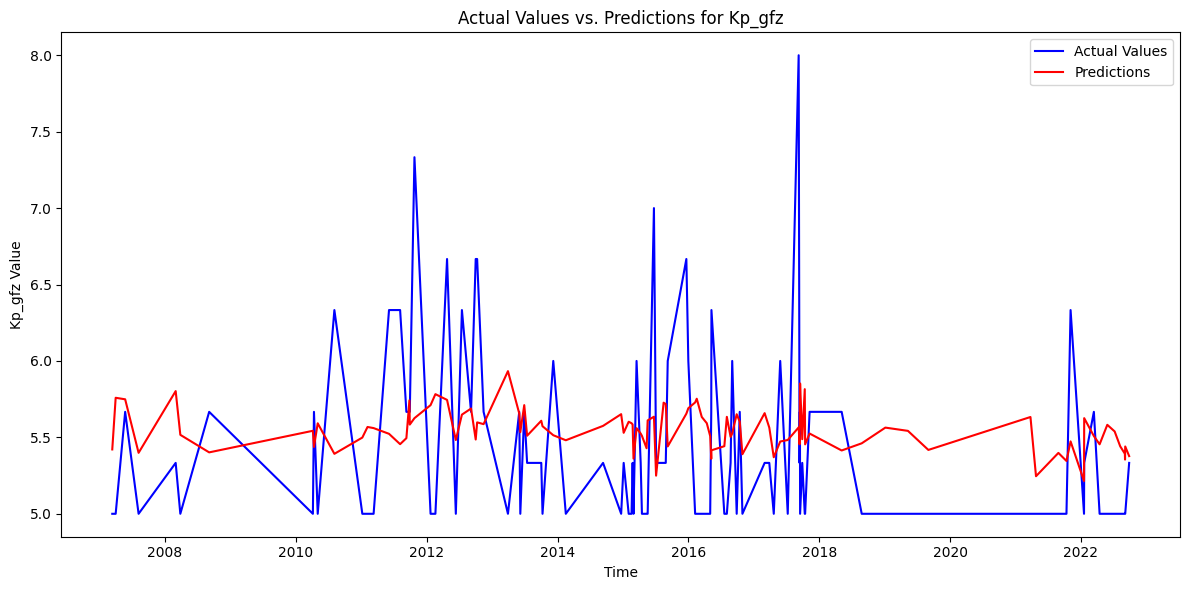

In [159]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
df = greater_data
# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)']
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(100,return_sequences = True, input_shape=(n_lags, len(columns_to_lag))))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\445959209.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{column}_lag_{i}'] = data[column].shift(i)
C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\445959209.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\Swaroop\AppData\Local\Temp\ipykernel_5248\445959209.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Epoch 1/200
168/168 [==============================] - 2s 5ms/step - loss: 1.9659
Epoch 2/200
168/168 [==============================] - 1s 4ms/step - loss: 1.5520
Epoch 3/200
168/168 [==============================] - 1s 4ms/step - loss: 1.5175
Epoch 4/200
168/168 [==============================] - 1s 4ms/step - loss: 1.4920
Epoch 5/200
168/168 [==============================] - 1s 5ms/step - loss: 1.4695
Epoch 6/200
168/168 [==============================] - 1s 4ms/step - loss: 1.4475
Epoch 7/200
168/168 [==============================] - 1s 4ms/step - loss: 1.4241
Epoch 8/200
168/168 [==============================] - 1s 4ms/step - loss: 1.4179
Epoch 9/200
168/168 [==============================] - 1s 5ms/step - loss: 1.4033
Epoch 10/200
168/168 [==============================] - 1s 5ms/step - loss: 1.3963
Epoch 11/200
168/168 [==============================] - 1s 4ms/step - loss: 1.3888
Epoch 12/200
168/168 [==============================] - 1s 4ms/step - loss: 1.3661
Epoch 13/200


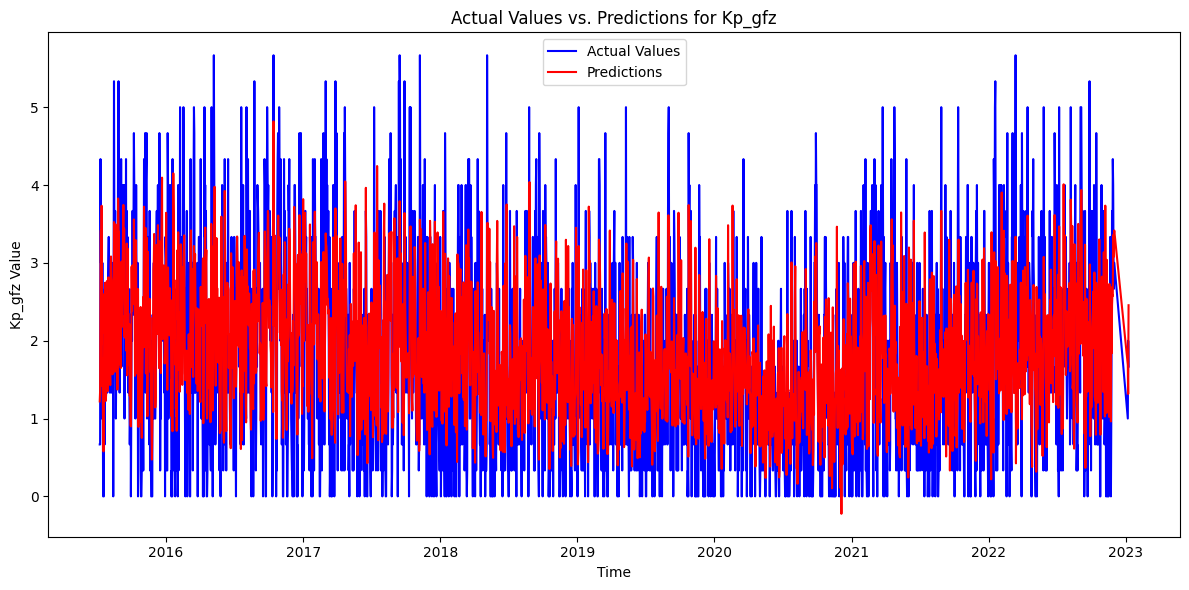

In [157]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
df = lesser_data
# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)']
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, len(columns_to_lag))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()


In [160]:
df = df2
df.columns

Index(['YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz', 'Kp_gfz_lag_1', 'Kp_gfz_lag_2', 'Kp_gfz_lag_3',
       'Kp_gfz_lag_4', 'Kp_gfz_lag_5', 'Kp_gfz_lag_6',
       'SW Proton Density, N/cm^3_lag_1', 'SW Proton Density, N/cm^3_lag_2',
       'SW Proton Density, N/cm^3_lag_3', 'SW Proton Density, N/cm^3_lag_4',
       'SW Proton Density, N/cm^3_lag_5', 'SW Proton Density, N/cm^3_lag_6',
       'SW Plasma Speed, km/s_lag_1', 'SW Plasma Speed, km/s_lag_2',
       'SW Plasma Speed, km/s_lag_3', 'SW Plasma Speed, km/s_lag_4',
       'SW Plasma Speed, km/s_lag_5', 'SW Plasma Speed, km/s_lag_6',
       'Vector B Magnitude, nT_lag_1', 'Vector B Magnitude, nT_lag_2',
       'Vector B Magnitude, nT_lag_3', 'Vector B Magnitude, 

In [162]:
df.columns

Index(['Date', 'YEAR', 'DOY', 'HR', 'Scalar B, nT', 'Vector B Magnitude, nT',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'SW Proton Density, N/cm^3',
       'SW Plasma Speed, km/s', 'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'Kp_gfz'],
      dtype='object')

In [184]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame with columns 'B' and 'Bz'
# If the DataFrame is not named 'df', replace 'df' with the actual DataFrame name
df = pd.read_csv("Data Files/CSV_files/omni_Kp_combined.csv")
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)

# # [['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT']]
df = df[(df.index>'2000-01-01') & (df.index < '2014-12-31')] 

# Create a new column 'theta' in the DataFrame 'df'
# df = pd.read_csv("Data Files/CSV_files/omni_Kp_combined.csv")
df['theta'] = np.arccos(df['BZ, nT (GSM)'] / np.abs(df['Vector B Magnitude, nT']))

df['theta'] = np.degrees(df['theta'])


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [185]:
v = df['Vector B Magnitude, nT']
B = df['SW Plasma Speed, km/s']
D = df['SW Proton Density, N/cm^3']
theta = df['theta'] 
BI = (10**-4 * v**2) + (11.7 * B * (np.sin(theta/2)**3))
df['BI'] = BI

dp =1.6726e-6 * D *  (v**2)
df['DP'] = dp



In [ ]:
df_copy = df

In [169]:
drop_cols = ['YEAR', 'DOY', 'HR',
       'Lat. Angle of B (GSE)', 'Long. Angle of B (GSE)', 
       'Kp index', 'R (Sunspot No.)', 'ap_index, nT',
       'f10.7_index', 'theta' ]

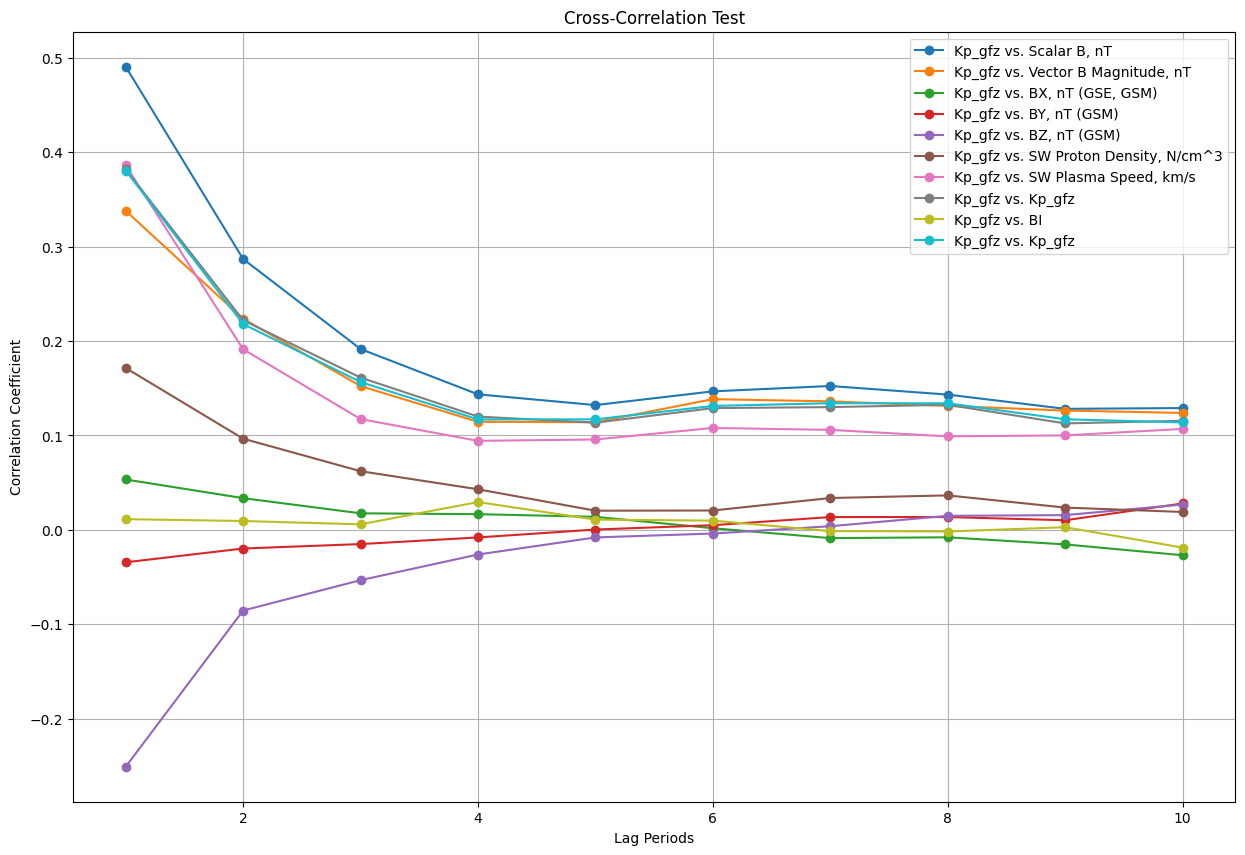

In [170]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
# df = pd.read_csv("Data Files/CSV_files/omni_Kp_combined.csv")

def perform_cross_correlation_test(variable1, variable2, lag_periods):
    lags = []
    correlations = []
    for lag in range(1, lag_periods+1):
        df[f'{variable1}_lag_{lag}'] = df[variable1].shift(lag)
        df[f'{variable2}_lag_{lag}'] = df[variable2].shift(lag)
        df_lagged = df.dropna()
        result = np.corrcoef(df_lagged[variable1], df_lagged[f'{variable2}_lag_{lag}'])[0, 1]
        lags.append(lag)
        correlations.append(result)
    
    return lags, correlations



def perform_autocorrelation_test(variable, lag_periods):
    lags = []
    correlations = []
    for lag in range(1, lag_periods+1):
        df[f'{variable}_lag_{lag}'] = df[variable].shift(lag)
        df_lagged = df.dropna()
        result = np.corrcoef(df_lagged[variable], df_lagged[f'{variable}_lag_{lag}'])[0, 1]
        lags.append(lag)
        correlations.append(result)
    
    return lags, correlations

# Replace 'kp' and 'ap' with the actual column names you want to test for cross-correlation
variable1_name = 'Kp_gfz'

plt.figure(figsize=(15, 10))
for column_name in df.drop(columns = drop_cols).columns:
    # print(column_name)
    
    lags, correlations = perform_cross_correlation_test(variable1_name, column_name, lag_periods=10)

    # Plotting the line plot
   
    plt.plot(lags, correlations, marker='o', linestyle='-', label=f'{variable1_name} vs. {column_name}')
    plt.xlabel('Lag Periods')
    plt.ylabel('Correlation Coefficient')
    plt.title(f'Cross-Correlation Test')
    plt.grid(True)




lags, correlations = perform_autocorrelation_test(variable1_name, lag_periods=10)

# Plotting the line plot
# plt.figure(figsize=(8, 6))
plt.plot(lags, correlations, marker='o', linestyle='-',  label = f'{variable1_name} vs. {variable1_name}' )
plt.legend()
plt.show()


Epoch 1/200
65/65 [==============================] - 4s 8ms/step - loss: 3.2825
Epoch 2/200
65/65 [==============================] - 0s 6ms/step - loss: 1.8952
Epoch 3/200
65/65 [==============================] - 0s 6ms/step - loss: 1.8591
Epoch 4/200
65/65 [==============================] - 0s 6ms/step - loss: 1.8284
Epoch 5/200
65/65 [==============================] - 0s 6ms/step - loss: 1.8156
Epoch 6/200
65/65 [==============================] - 0s 6ms/step - loss: 1.7969
Epoch 7/200
65/65 [==============================] - 0s 6ms/step - loss: 1.7867
Epoch 8/200
65/65 [==============================] - 0s 5ms/step - loss: 1.7785
Epoch 9/200
65/65 [==============================] - 0s 7ms/step - loss: 1.7740
Epoch 10/200
65/65 [==============================] - 0s 5ms/step - loss: 1.7801
Epoch 11/200
65/65 [==============================] - 0s 5ms/step - loss: 1.7717
Epoch 12/200
65/65 [==============================] - 0s 5ms/step - loss: 1.7741
Epoch 13/200
65/65 [=================

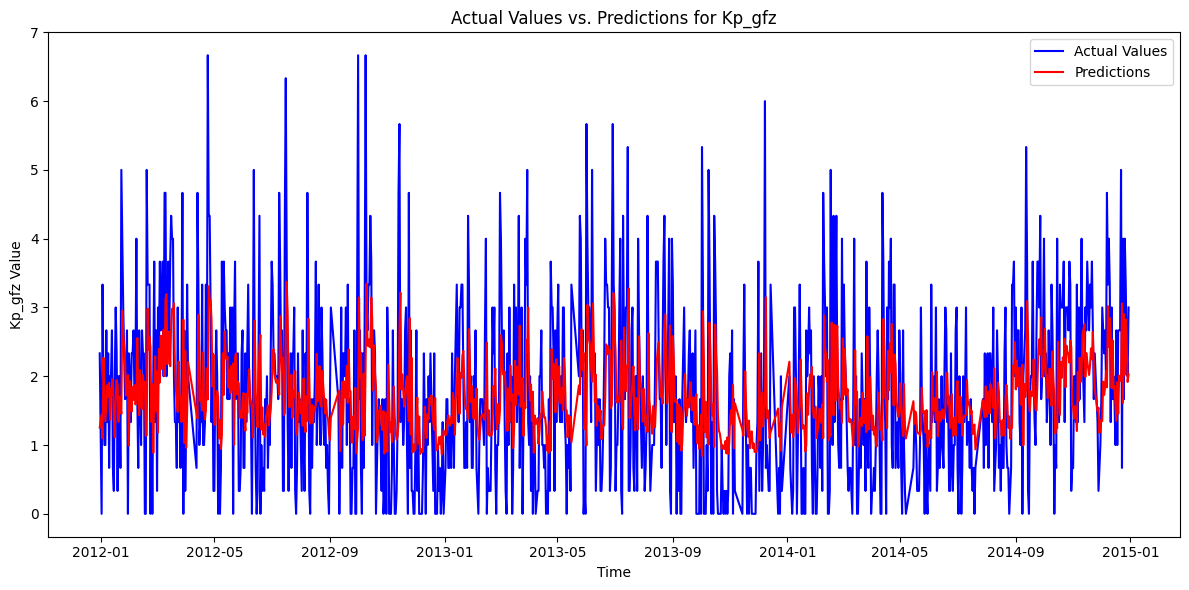

In [178]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz','BI' ]
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, len(columns_to_lag))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/200
63/63 [==============================] - 2s 5ms/step - loss: 3.0907
Epoch 2/200
63/63 [==============================] - 0s 5ms/step - loss: 1.8551
Epoch 3/200
63/63 [==============================] - 0s 5ms/step - loss: 1.8477
Epoch 4/200
63/63 [==============================] - 0s 5ms/step - loss: 1.8076
Epoch 5/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7783
Epoch 6/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7619
Epoch 7/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7658
Epoch 8/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7575
Epoch 9/200
63/63 [==============================] - 0s 4ms/step - loss: 1.7613
Epoch 10/200
63/63 [==============================] - 0s 4ms/step - loss: 1.7398
Epoch 11/200
63/63 [==============================] - 0s 4ms/step - loss: 1.7359
Epoch 12/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7326
Epoch 13/200
63/63 [=================

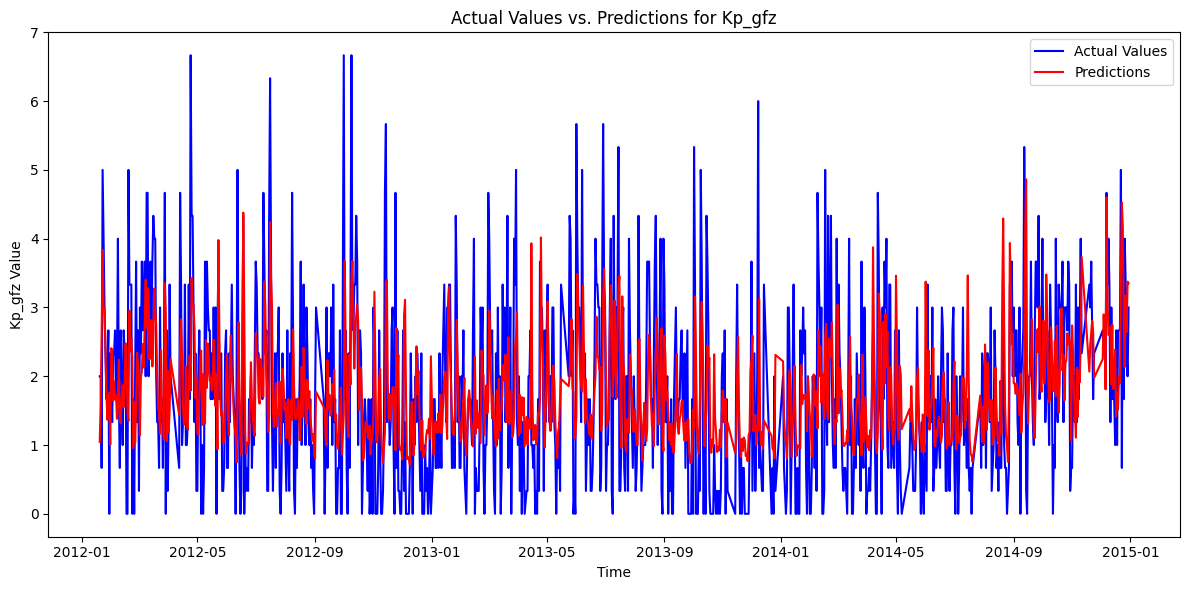

In [183]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz','BI', "DP" ]
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, len(columns_to_lag))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/200
63/63 [==============================] - 2s 5ms/step - loss: 2.8242
Epoch 2/200
63/63 [==============================] - 0s 5ms/step - loss: 1.9089
Epoch 3/200
63/63 [==============================] - 0s 4ms/step - loss: 1.8565
Epoch 4/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7696
Epoch 5/200
63/63 [==============================] - 0s 4ms/step - loss: 1.6509
Epoch 6/200
63/63 [==============================] - 0s 4ms/step - loss: 1.6005
Epoch 7/200
63/63 [==============================] - 0s 4ms/step - loss: 1.5457
Epoch 8/200
63/63 [==============================] - 0s 4ms/step - loss: 1.5285
Epoch 9/200
63/63 [==============================] - 0s 4ms/step - loss: 1.5040
Epoch 10/200
63/63 [==============================] - 0s 4ms/step - loss: 1.4814
Epoch 11/200
63/63 [==============================] - 0s 4ms/step - loss: 1.4695
Epoch 12/200
63/63 [==============================] - 0s 5ms/step - loss: 1.4748
Epoch 13/200
63/63 [=================

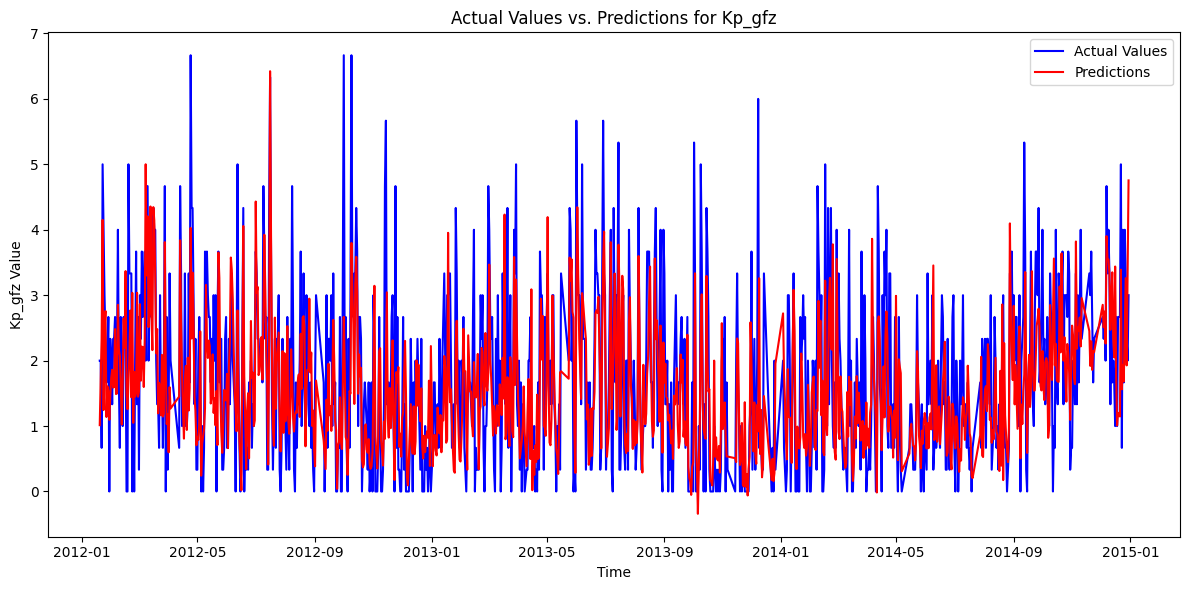

In [186]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming df contains columns 'Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', and 'Vector B Magnitude, nT'
# Make sure the DataFrame is sorted by datetime in ascending order

# Function to create lagged columns for a given column up to 'n_lags' timesteps
def create_lagged_columns(data, column, n_lags):
    for i in range(1, n_lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

# Create lagged columns for each specified column up to 6 timesteps
columns_to_lag = ['Kp_gfz', 'SW Proton Density, N/cm^3', 'SW Plasma Speed, km/s', 'Vector B Magnitude, nT', 'BX, nT (GSE, GSM)',
       'BY, nT (GSM)', 'BZ, nT (GSM)', 'BI']
n_lags = 6
for column in columns_to_lag:
    df = create_lagged_columns(df, column, n_lags)

# Drop rows with NaN values resulting from the lagged columns
df.dropna(inplace=True)

# Define the target column ('Kp_gfz') as the label
labels = df['Kp_gfz'].values
df.dropna(inplace = True)

# Select the lagged columns and other features as inputs
lagged_columns = [f'{column}_lag_{i}' for column in columns_to_lag for i in range(1, n_lags + 1)]
features = df[lagged_columns].values

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, shuffle=False)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_lags, len(columns_to_lag))
X_test = X_test.reshape(X_test.shape[0], n_lags, len(columns_to_lag))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, len(columns_to_lag))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=64)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Make predictions for the test data
predictions = model.predict(X_test)

# # Inverse transform the predictions to get the original scale
# predictions_inverse = scaler.inverse_transform(predictions)

# # Inverse transform the test data labels to get the original scale for "Kp_gfz"
# y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot the graph comparing the actual values with the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Values', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Kp_gfz Value')
plt.title('Actual Values vs. Predictions for Kp_gfz')
plt.legend()
plt.tight_layout()
plt.show()
